# Synaptic Conductance Model to Simulate an EPSP

Simple mechanistic model of synaptic conductance for simulating an EPSP. Completely based off Trappenberg, 2022 textbook (see *References* section). My only contribution is refactoring the model implementation to make it easier to run simulations with different parameters and comparing results. I run a couple of experiments to showcase.

In [1]:
import matplotlib.pyplot as plt

## Model description

- A segment of dendrite is treated as compartment with a leaky capacitor and a neurotransmitter-gatted resistor.
- Each resistor has a battery representing the concentration gradients of the neuron. 
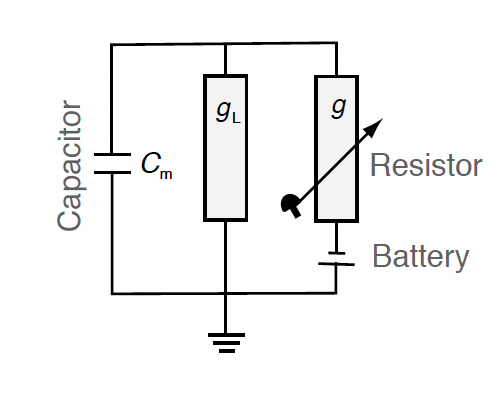

**Kirchhoff's of conservation of electric charge** establishes that:

$$c_m \dfrac{dV_m(t)}{dt} = -I$$

- Minus sign in current is convention in neuroscience (current is measured as flowing from outside to inside of cell)

The current is produced by two channels: 
1. The leakage channel with conductance $g_L$ and resting potential of 0
2. Neurotransmitter-gated synaptic ion channel with time-varying conductance $g_{syn}(t)$ and resting potential $E_{syn}$

By **Ohm's law**: 

$$ I(t) = g_L V_m(t) + g_{syn}(t)(V_m(t) - E_{syn})$$

The time-varying synaptic conductance is modelled with a simple model of the average channel dynamics, where we assume that many channels open immediately after binding neurotransmitters, but close stochastically. This is given by:

$$ \tau_{syn} \dfrac{dg_{syn}(t)}{dt} = -g_{syn}(t) + \delta(t - t_{pre} - t_{delay})$$

- Note that the contribution of the delta function happens at time $t_{delay} + t_{pre}$ to account for the delay ($t_{delay}$) after the time at which the presynaptic spike occured ($t_{pre}$)
- $\tau_{syn}$ is the constant of the exponential decay

### Euler's method

The update rules for silving the system numerically via Euler's method can be derived.

First, from the law of conservation of electric charge:

$$ \dfrac{dV_m(t)}{dt} = \dfrac{-I(t)}{c_m} $$

And from the equation of average channel dynamics:

$$ \dfrac{dg_{syn}(t)}{dt} = \dfrac{ -g_{syn}(t) + \delta(t - t_{pre} - t_{delay})}{\tau_{syn}}$$

Then the update rules for a discrete time step, $\Delta t$ are:

$$ V_m(t + \Delta t) = V_m(t) + \Delta t \dfrac{-I(t)}{c_m}$$

$$ g_{syn}(t + \Delta t) = g_{syn}(t) + \Delta t \dfrac{ -g_{syn}(t) + \delta(t - t_{pre} - t_{delay})}{\tau_{syn}}$$

## Simulations

Using Euler's method simulate the system dynamics

In [30]:
# Some auxiliary functions for modularity and easier readability

def update_v_m(prev_v_m, timestep, c_m, I):
    """
    Performs update for v_m according to Euler's method
    """
    return prev_v_m + timestep*(-I / c_m)

def update_g_syn(prev_g_syn, timestep, current_t, tau, t_pre, t_delay):
    """
    Performs update for g_syn according to Euler's method
    """
    if abs(current_t - t_pre - t_delay) < 0.0001:
        # Big contribution from delta function
        return 1
    else:
        # No contribution from delta function
        return prev_g_syn + timestep*(-prev_g_syn / tau)
    
def compute_current(g_l, v_m, g_syn, E_syn):
    """
    Computes total current to use in update rules
    """
    return g_l*v_m + g_syn*(v_m - E_syn)
    
def simulate(final_t, c_m=1, E_l=0, E_syn=10, tau=1, timestep=0.1, g_l=1,
            t_pre=0.5, t_delay=0.5):
    # Preset trajectory vectors
    total_steps = int(final_t/timestep)
    g_syn =  [None]*total_steps
    I = [None]*total_steps
    v_m = [None]*total_steps
    t = [None]*total_steps
    # Initial values
    g_syn[0] = 0
    I[0] = 0
    v_m [0] = 0
    t[0] = 0
    # Update trajectories
    for current_step in range(1, total_steps):
        t[current_step] = t[current_step - 1] + timestep
        g_syn[current_step] = update_g_syn(g_syn[current_step - 1], 
                                           timestep, t[current_step], 
                                           tau, t_pre, t_delay)
        v_m[current_step] = update_v_m(v_m[current_step - 1], 
                                       timestep, c_m, I[current_step - 1])
        I[current_step] = compute_current(g_l, v_m[current_step], 
                                          g_syn[current_step], E_syn)
    return {"t": t,
            "I": I,
            "v_m": v_m,
            "g_syn": g_syn}

def plot_simulation(trajectories_dict):
    fig, ax = plt.subplots(3,1,figsize=(10,18))
    ax[0].plot(trajectories_dict["t"], trajectories_dict["v_m"])
    ax[0].set_xlabel("t (ms)", fontsize=12)
    ax[0].set_ylabel("$V_m$", fontsize=12)
    ax[1].plot(trajectories_dict["t"], trajectories_dict["I"])
    ax[1].set_xlabel("t (ms)", fontsize=12)
    ax[1].set_ylabel("I", fontsize=12)
    ax[2].plot(trajectories_dict["t"], trajectories_dict["g_syn"])
    ax[2].set_ylabel("$g_{syn}$", fontsize=12)
    ax[2].set_xlabel("t (ms)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
def plot_simulation_against_baseline(trajectories_dict, baseline_trajectories):
    fig, ax = plt.subplots(3,1,figsize=(10,18))
    ax[0].plot(baseline_trajectories["t"], baseline_trajectories["v_m"],
              label="baseline")
    ax[0].plot(trajectories_dict["t"], trajectories_dict["v_m"],
              label="new setting")
    ax[0].set_xlabel("t (ms)", fontsize=12)
    ax[0].set_ylabel("$V_m$", fontsize=12)
    ax[0].legend()
    ax[1].plot(baseline_trajectories["t"], baseline_trajectories["I"],
              label="baseline")
    ax[1].plot(trajectories_dict["t"], trajectories_dict["I"],
              label="new setting")
    ax[1].set_xlabel("t (ms)", fontsize=12)
    ax[1].set_ylabel("I", fontsize=12)
    ax[1].legend()
    ax[2].plot(baseline_trajectories["t"], baseline_trajectories["g_syn"],
              label="baseline")
    ax[2].plot(trajectories_dict["t"], trajectories_dict["g_syn"],
              label="new setting")
    ax[2].set_ylabel("$g_{syn}$", fontsize=12)
    ax[2].set_xlabel("t (ms)", fontsize=12)
    ax[2].legend()
    plt.tight_layout()
    plt.show()

### Basline

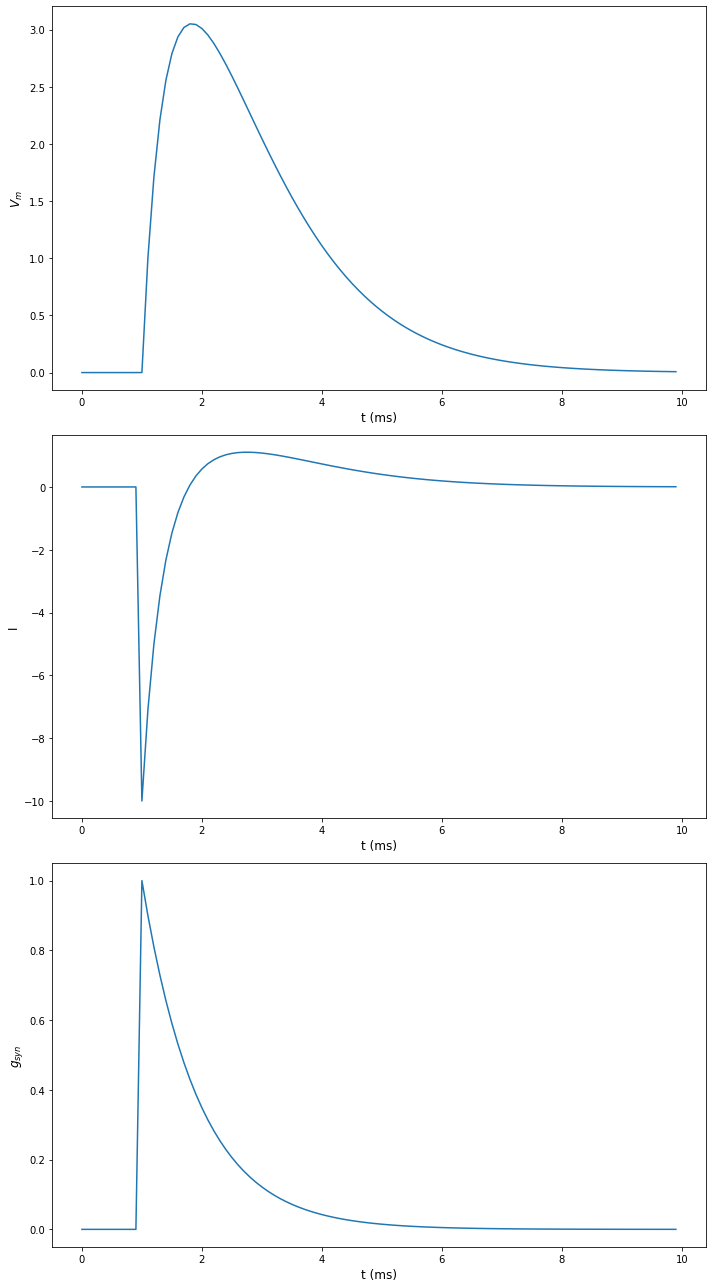

In [31]:
baseline_results = simulate(10)
plot_simulation(baseline_results)

### Larger leakage conductance 

Set $g_L = 1.30$ instead of baseline $g_L = 1$

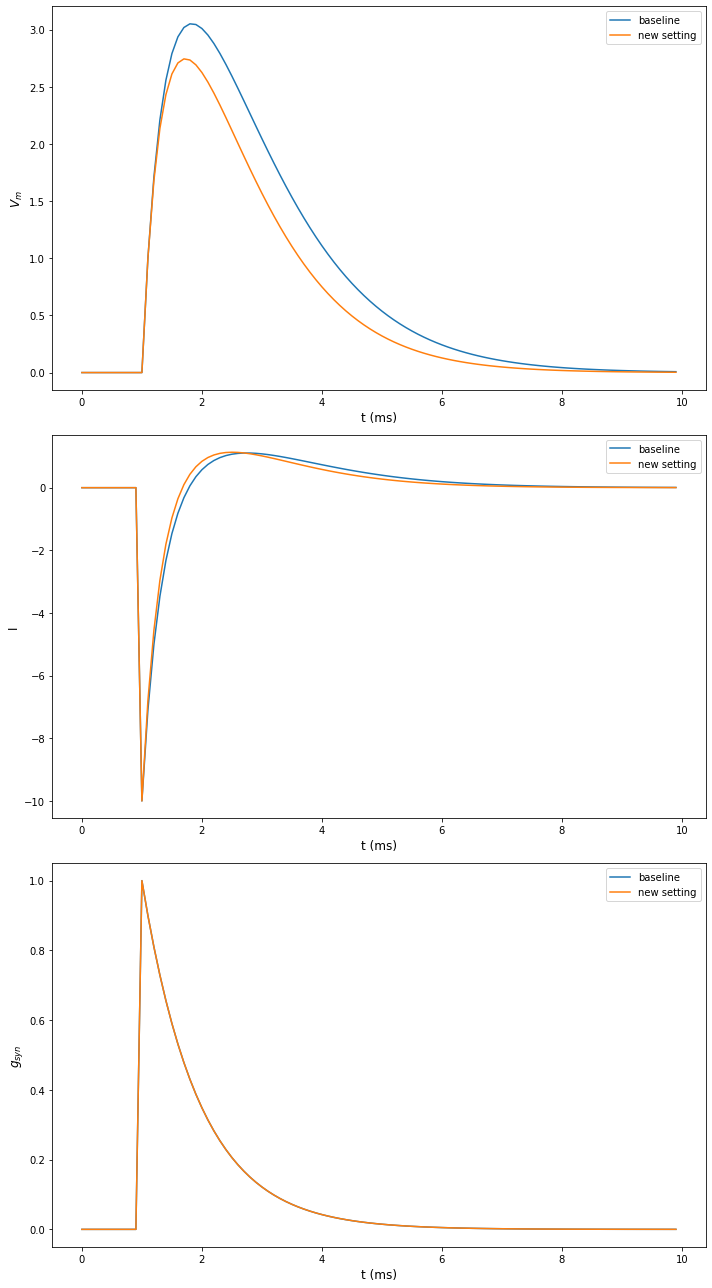

In [34]:
results = simulate(10, g_l=1.30)
plot_simulation_against_baseline(results, baseline_results)

### Larger delay in synaptic channel 

Set $t_{delay} = 1$ instead of baseline $t_{delay} = 0.5$

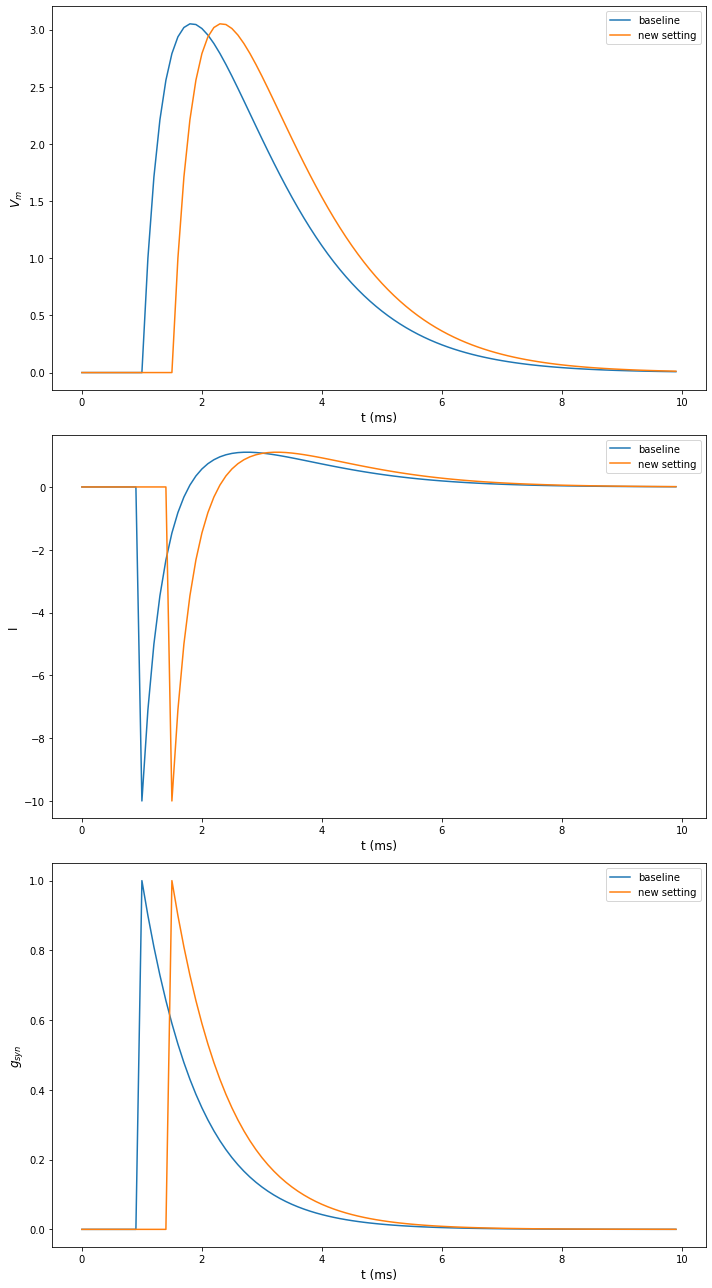

In [38]:
results = simulate(10, t_delay=1)
plot_simulation_against_baseline(results, baseline_results)

## References

Trappenberg, Thomas P., Fundamentals of Computational Neuroscience: Third Edition, 3rd edn, Ch. 3, pp. 72-75
(Oxford, 2022; online edn, Oxford Academic, 19 Jan. 2023), https://doi.org/10.1093/oso/9780192869364.001.0001, accessed 18 Aug. 2023.